# **Emotion Peaks PLS**

This notebook is for the analysis of the data that are produced from peaks_PLS.py. 

It is divided into:
1. **Data loading**
2. **Single Emotions peaks**
3. **Mean of emotions**
4. **Magnitude of emotions**

In [76]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers_PLS import *

Counting points function is used to count the number of peaks in each emotion.

In [77]:
emotions = ['Happiness', 'Sad', 'Anxiety', 'Love', 'Fear', 'WarmHeartedness', 'Regard']
list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']
thresholds = [1, 1.5, 2]

count_pts = counting_points(list_movies, thresholds, emotions)
print(count_pts)

{1: {'Happiness': 512, 'Sad': 946, 'Anxiety': 833, 'Love': 729, 'Fear': 724, 'WarmHeartedness': 769, 'Regard': 583, 'All Movie': 7385}, 1.5: {'Happiness': 221, 'Sad': 548, 'Anxiety': 475, 'Love': 345, 'Fear': 379, 'WarmHeartedness': 397, 'Regard': 323, 'All Movie': 7385}, 2: {'Happiness': 101, 'Sad': 243, 'Anxiety': 245, 'Love': 46, 'Fear': 217, 'WarmHeartedness': 189, 'Regard': 42, 'All Movie': 7385}}


Read the data on the peaks for the concatenated movie.

In [78]:
# Read the data of the PLS calculated on the peaks of the emotions  for the concatenated movies
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_concat.csv')
peaks_data.dropna(inplace=True)
peaks_data = peaks_data[peaks_data['Region'] == 'ALL']

movies = peaks_data['Movie'].unique()                                   # list of the movies
emotions_control = peaks_data['Emotion'].unique()                       # list of the emotions
emotions = [x for x in emotions_control if not x.startswith('Control')] # list of the emotions without the control ones
thresholds = peaks_data['threshold'].unique()                           # list of the thresholds

# Read the data for the PLS computed on all the movies concatenated
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_bold_ALL_concatmovies.csv', index_col=0).reset_index().drop(columns=['Movie', 'LC'])
data_all['Region'] = 'ALL'
data_all['Type'] = 'bold'
data_all.reset_index(inplace=True, drop=False)
data_all.rename(columns={'index': 'bootstrap_round'}, inplace=True)
data_all.head(1)

,bootstrap_round,Covariance Explained,P-value,Region,Type
0,0,0.521576,0.032967,ALL,bold


1


TypeError: 'Axes' object is not subscriptable

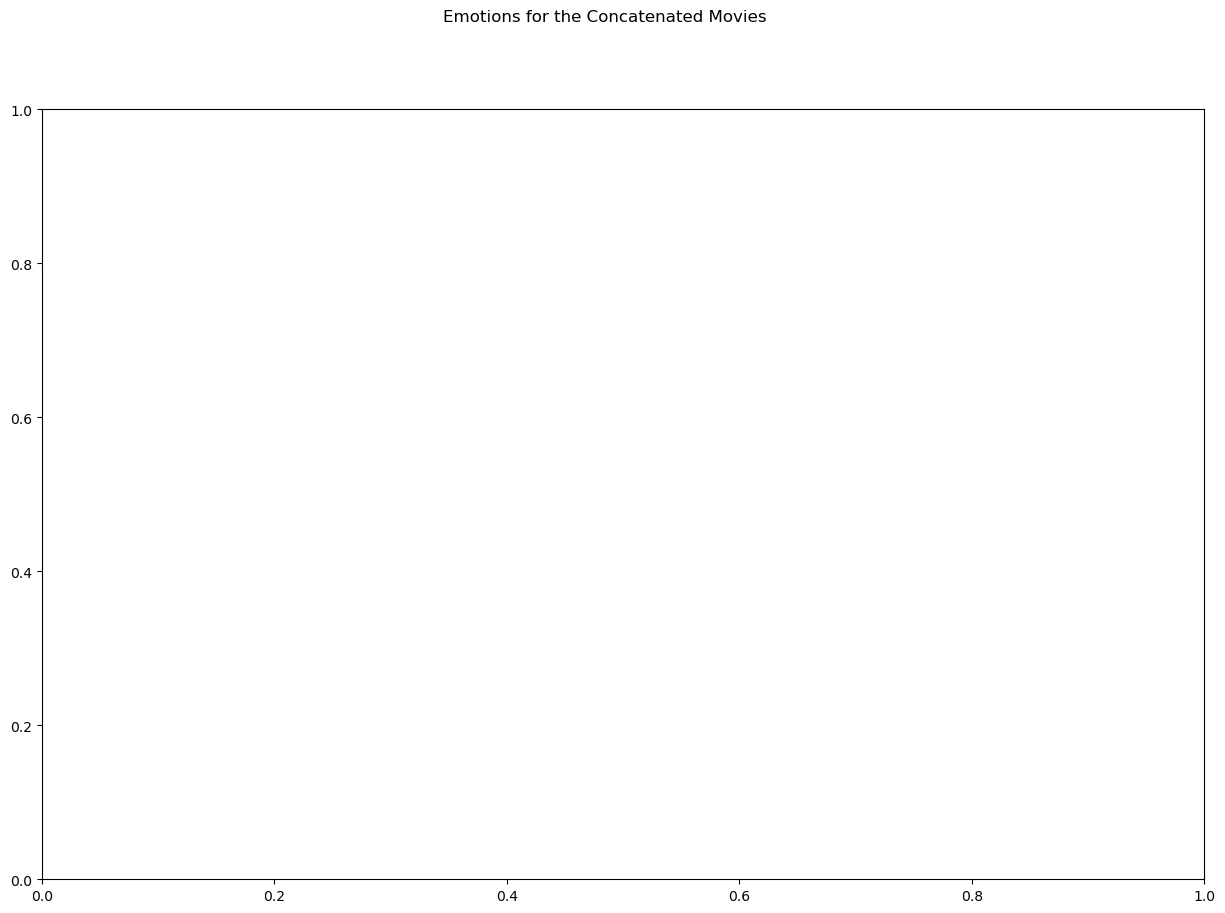

In [80]:
concat_emo = pd.DataFrame()
for movie in list_movies:
    labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
    data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
    data.columns = labels['Columns']
    concat_emo = pd.concat([concat_emo, data], axis = 0)
    concat_emo.reset_index(drop=True, inplace=True)

palette = sns.color_palette("Set2", len(emotions))

# Determine the layout of the subplots
print(len(emotions))
n_rows = int(len(emotions) ** 0.5)
n_cols = int(len(emotions) / n_rows) + (len(emotions) % n_rows > 0)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust figsize as needed
fig.suptitle('Emotions for the Concatenated Movies')

for i, emotion in enumerate(emotions):
    # Determine the current subplot row and column
    row = i // n_cols
    col = i % n_cols

    if n_rows > 1:
        ax = axes[row, col]
    else:
        ax = axes[col]

    ax.plot(concat_emo[emotion], label=emotion, color=palette[i])
    ax.set_title(emotion)
    ax.set_xlabel('Time')
    ax.set_ylabel('Intensity')
    ax.axhline(y=1, color='grey', linestyle='-')
    ax.axhline(y=2, color='red', linestyle='-')
    ax.axhline(y=1.5, color='blue', linestyle='-')
    ax.legend()

fig.delaxes(axes[1, 3])
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust this as needed for the title
plt.show()


In [ ]:
significant_peaks = peaks_data[peaks_data['P-value'] < 0.05]
significant_peaks = significant_peaks.groupby(['Region', 'bootstrap_round', 'Emotion', 'threshold']).sum()['Covariance Explained'].reset_index()
significant_peaks['Control'] = significant_peaks['Emotion'].apply(lambda x: 1 if x.split('_')[0] == 'Control' else 0)
significant_peaks['Emotion'] = significant_peaks['Emotion'].apply(lambda x: x.split('_')[-1])


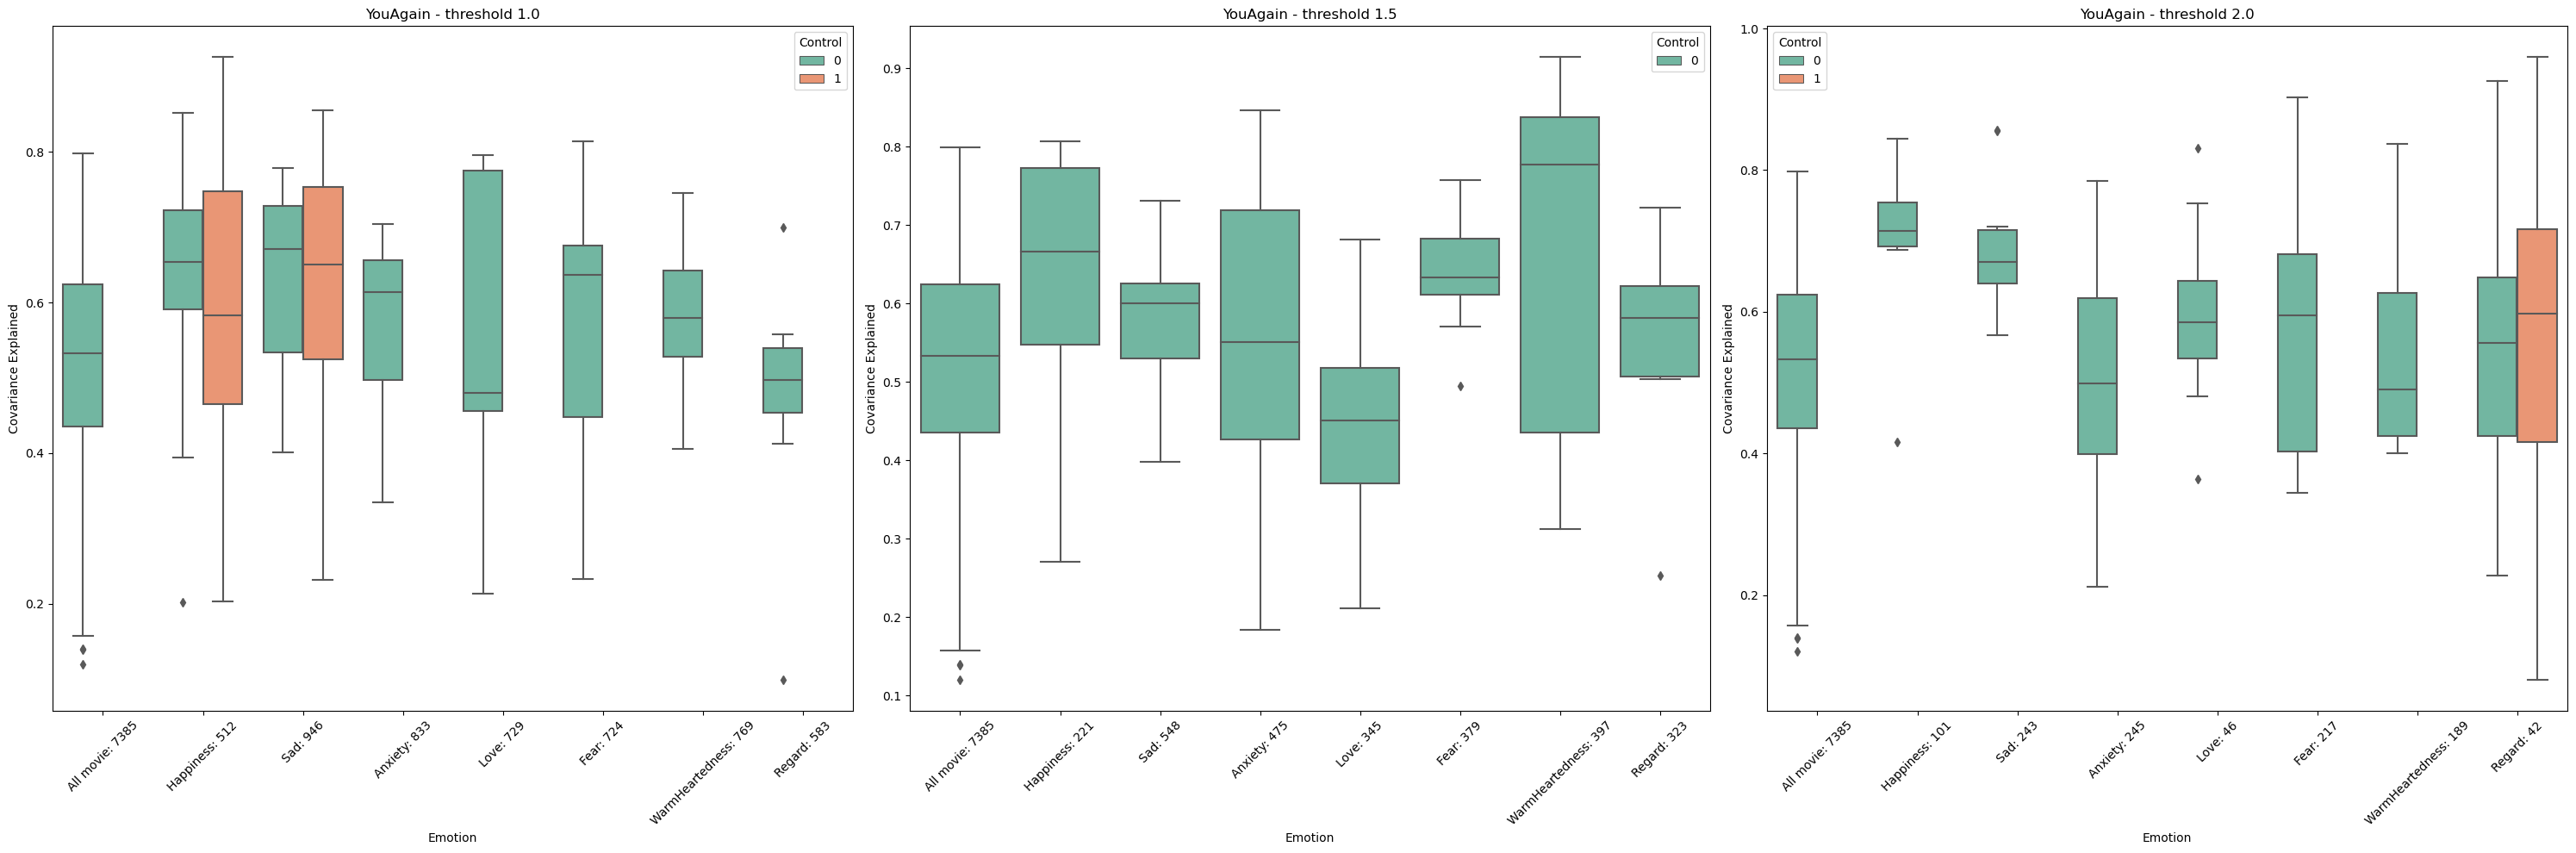

In [ ]:
thresholds = [1, 1.5, 2]

def retrieve_significant_data(peaks_data, data_all_movie, count_pts, thresholds, emotions):

    # Take the significant LC for the PLS on the peaks
    significant_peaks = peaks_data[peaks_data['P-value'] < 0.05]
    significant_peaks = significant_peaks.groupby(['Region', 'bootstrap_round', 'Emotion', 'threshold']).sum()['Covariance Explained'].reset_index()
    significant_peaks['Control'] = significant_peaks['Emotion'].apply(lambda x: 1 if x.split('_')[0] == 'Control' else 0)
    significant_peaks['Emotion'] = significant_peaks['Emotion'].apply(lambda x: x.split('_')[-1])

    # Take the significant LC for the PLS on all the movie
    data_all_movie['Emotion'] = 'All movie'
    significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
    significant_all_movie = significant_all_movie.groupby(['Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()
    significant_all_movie['Control'] = 0

    # Merge the dataframes
    significant = pd.concat([significant_peaks, significant_all_movie], ignore_index=True)

    for emotion in emotions:
        for thr in thresholds:
            significant.loc[(significant['Emotion'] == emotion.split('_')[-1]) & (significant['threshold'] == thr), 'Number of points'] = count_pts[thr][emotion]
    significant.loc[significant['Emotion'] == 'All movie', 'Number of points'] = count_pts[thr]['All Movie']
    return significant

def plot_peaks(significant, emotions, thresholds):
    # Define your thresholds
    thresholds = [1.0, 1.5, 2.0]  # Example thresholds
    palette = sns.color_palette("Set2", 8)

    # Assuming 'significant' is your DataFrame and 'emotions' is defined
    order_emotions = ['All movie'] + emotions  # Adjusted for simplicity

    # Set up the subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))  # Adjust the size as needed

    for i, thr in enumerate(thresholds):
        # Filter data for the current threshold
        significant.loc[significant['Emotion'] == 'All movie', 'threshold'] = thr
        df_thr = significant[significant['threshold'] == thr]

        # Plot the boxplot in the i-th subplot
        sns.boxplot(x='Emotion', y='Covariance Explained', data=df_thr,  hue='Control',
                    palette=palette, order=order_emotions, ax=axes[i])

        # Adjust x-ticks
        list_n = []
        for emo in order_emotions:
            n = df_thr[df_thr['Emotion'] == emo.split('_')[0]]['Number of points'].unique()
            if len(n) == 0:
                n = 0
            else:
                n = n[0]
            list_n.append(f'{emo}: {int(n)}')

        axes[i].set_xticklabels(list_n, rotation=45)
        axes[i].set_title(f'{movie} - threshold {thr}')

    plt.tight_layout()
    plt.show()

significant = retrieve_significant_data(peaks_data, data_all, count_pts, thresholds, emotions)
plot_peaks(significant, emotions, thresholds)

## mean values

The shape of the data_concat is:  (7385, 50)


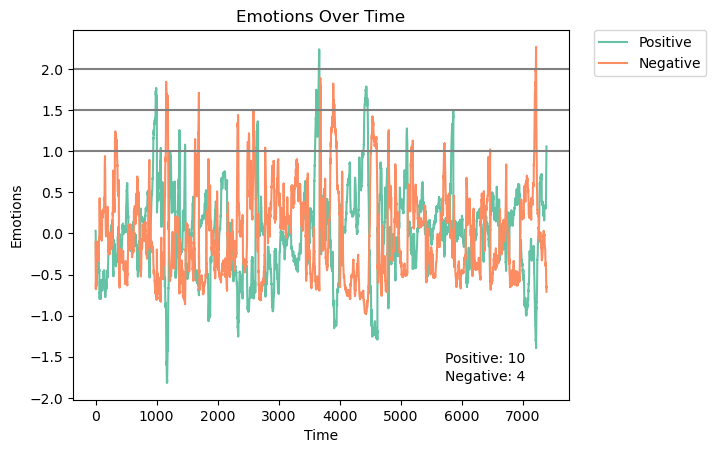

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def concat_emo(server = True):
    list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']
    data_concat = pd.DataFrame()
    for movie_name in list_movies:
        if server == True:
            PATH  = '/media/miplab-nas2/Data2/Movies_Emo/Flavia_E3/EmoData'
        else:
            PATH = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData'
        labels = pd.read_json(PATH + f'/Annot13_{movie_name}_stim.json')
        data = pd.read_csv(PATH + f'/Annot13_{movie_name}_stim.tsv', sep = '\t', header = None)
        data.columns = labels['Columns']
        data_concat = pd.concat([data_concat, data], axis=0)
    data_concat.reset_index(drop=True, inplace=True)
    print('The shape of the data_concat is: ', data_concat.shape)
    return data_concat

def count_emotions_above_threshold(data, threshold, emotions):
    """Counts the number of points above a given threshold for specified emotions."""
    return len(data[data[emotions].mean(axis=1) > threshold])

def plot_emotions(data, threshold, positive_count, negative_count):
    """Plots emotions with annotations."""
    sns.set_palette(sns.color_palette("Set2", 8))
    plt.plot(data['positive'], label='Positive', color=sns.color_palette()[0])
    plt.plot(data['negative'], label='Negative', color=sns.color_palette()[1])
    for thr in threshold:
        plt.axhline(y=thr, color='grey', linestyle='-')
    plt.xlabel('Time')
    plt.ylabel('Emotions')
    plt.title(f'Emotions Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.annotate(f'Positive: {positive_count}', xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate(f'Negative: {negative_count}', xy=(0.75, 0.05), xycoords='axes fraction')
    plt.show()

def counting_points(thresholds):
    """Counts the number of points above given thresholds for positive and negative emotions."""
    count_pts = {}
    positive_emotions = ['Love', 'Regard', 'WarmHeartedness', 'Pride', 'Satisfaction', 'Happiness']
    negative_emotions = ['Sad', 'Anxiety', 'Fear', 'Guilt', 'Disgust', 'Anger']

    data = concat_emo(server = False)
    data['positive'] = data[positive_emotions].mean(axis=1)
    data['negative'] = data[negative_emotions].mean(axis=1)

    for thr in thresholds:
        positive_count = count_emotions_above_threshold(data, thr, positive_emotions)
        negative_count = count_emotions_above_threshold(data, thr, negative_emotions)
        count_pts[thr] = {'positive': positive_count, 'negative': negative_count, 'All Movie': len(data)}
        
    plot_emotions(data, thresholds, positive_count, negative_count)

    return count_pts

# Example usage:
thresholds = [1, 1.5, 2]  # Example thresholds
results = counting_points(thresholds)

In [104]:
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSmean_concat.csv')
peaks_data.dropna(inplace=True)
peaks_data.head(1)

,Covariance Explained,P-value,Movie,LC,Region,bootstrap_round,Emotion,threshold
0,0.573707,0.002997,concatenated,1,ALL,0,positive,1.0


In [105]:
# Read the data for the PLS computed on all the movies concatenated
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_bold_ALL_concatmovies.csv', index_col=0).reset_index().drop(columns=['Movie', 'LC'])
data_all['Region'] = 'ALL'
data_all['Type'] = 'bold'
data_all['Emotion'] = 'All movie'
data_all.reset_index(inplace=True, drop=False)
data_all.rename(columns={'index': 'bootstrap_round'}, inplace=True)
data_all.head()

,bootstrap_round,Covariance Explained,P-value,Region,Type,Emotion
0,0,0.521576,0.032967,ALL,bold,All movie
1,1,0.139877,0.045954,ALL,bold,All movie
2,2,0.720825,0.000999,ALL,bold,All movie
3,3,0.119937,0.030969,ALL,bold,All movie
4,4,0.721690,0.000999,ALL,bold,All movie


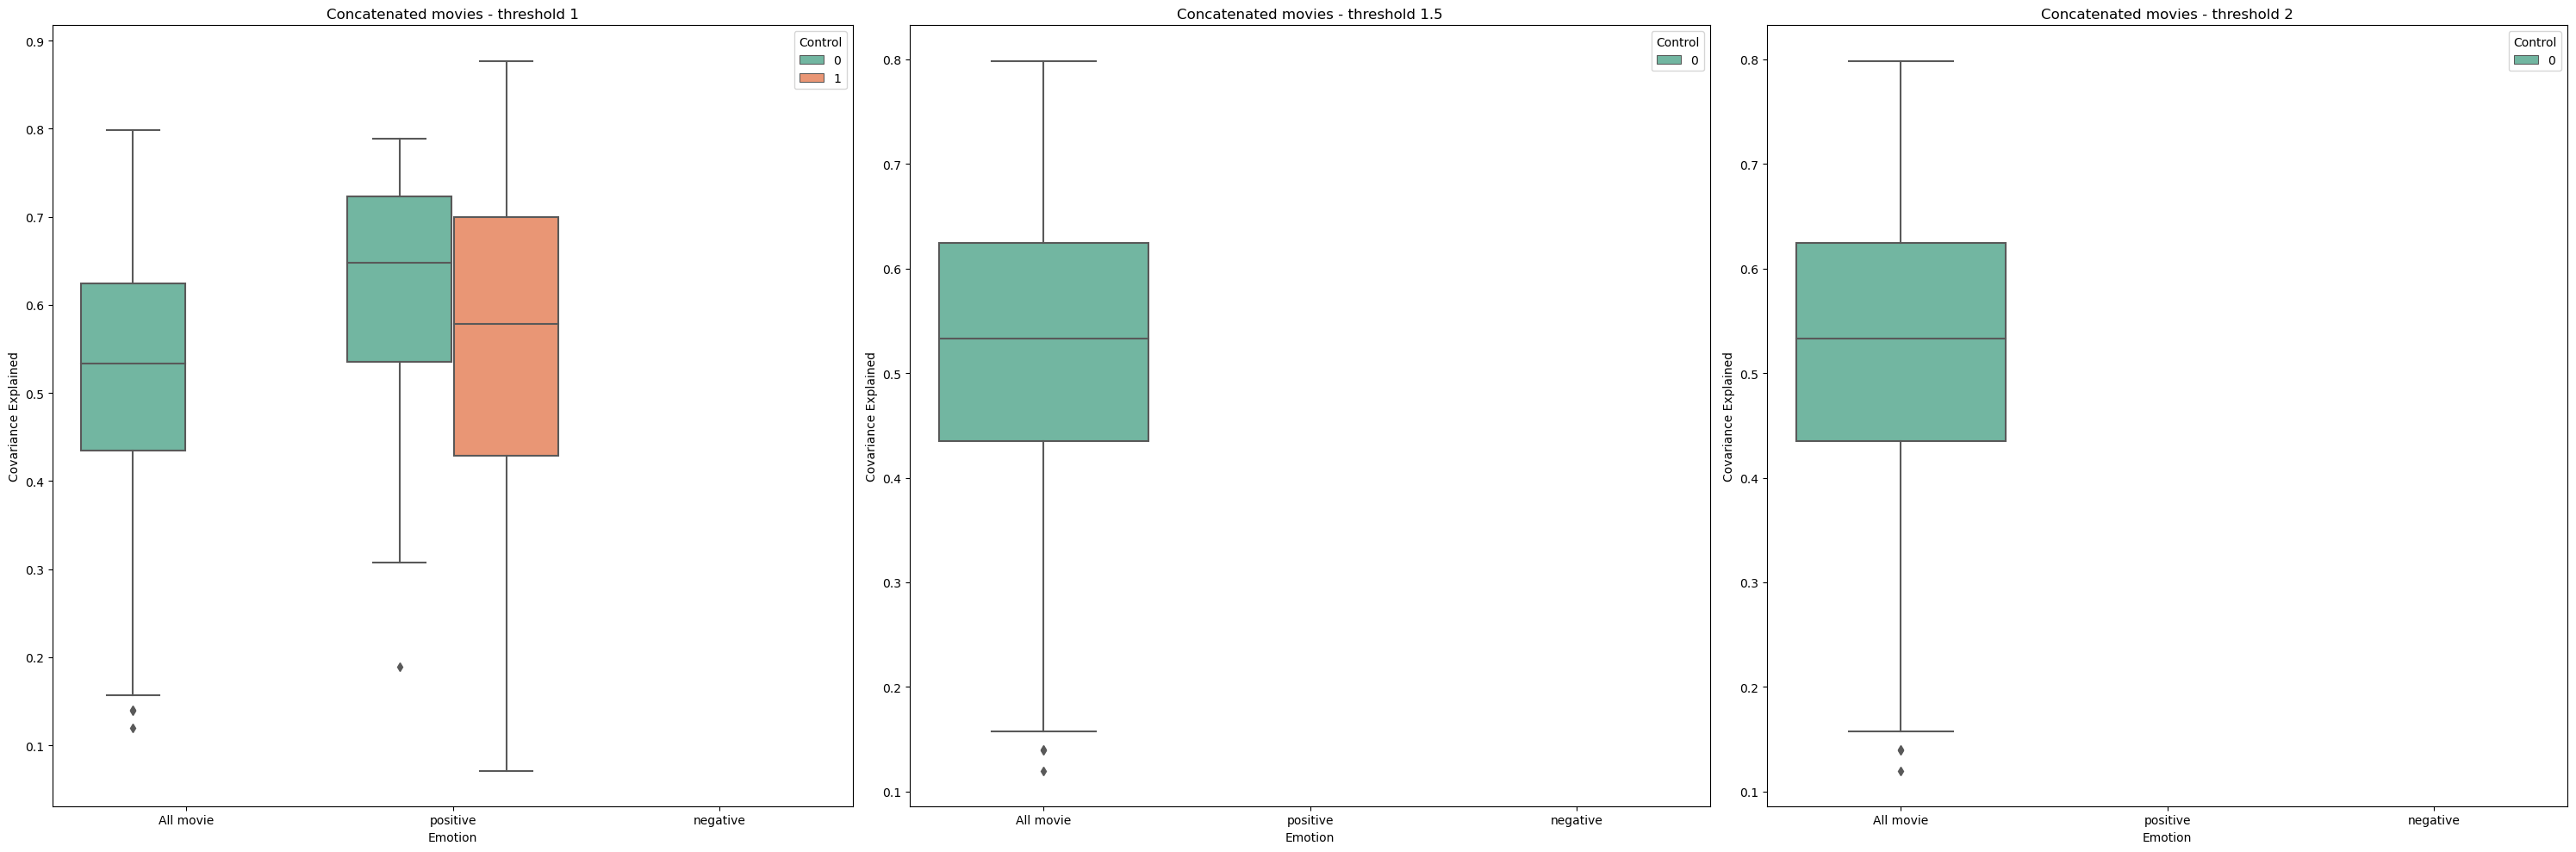

In [108]:
thresholds = [1, 1.5, 2]

def retrieve_significant_data_mean(peaks_data, data_all_movie):

    # read the emotion data columns:        Movie Region bootstrap_round emotion Covariance Explained
    significant = peaks_data[peaks_data['P-value'] < 0.05]
    significant = significant.groupby(['Region', 'bootstrap_round', 'Emotion', 'threshold']).sum()['Covariance Explained'].reset_index()
    significant['Control'] = significant['Emotion'].apply(lambda x: 1 if x.split('_')[0] == 'Control' else 0)
    significant['Emotion'] = significant['Emotion'].apply(lambda x: x.split('_')[-1])

    # significant all movie
    significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
    significant_all_movie = significant_all_movie.groupby(['Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()
    significant_all_movie['Control'] = 0

    # merge the three dataframes
    significant = pd.concat([significant, significant_all_movie], ignore_index=True)

    return significant

def plot_mean(significant, thresholds):
    # Define your thresholds
    palette = sns.color_palette("Set2", 8)

    # Create the subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(thresholds), figsize=(30, 10))  # Adjust the size as needed

    for i, thr in enumerate(thresholds):
        # Filter data for the current threshold
        significant.loc[significant['Emotion'] == 'All movie', 'threshold'] = thr
        df_thr = significant[significant['threshold'] == thr]

        # Plot the boxplot in the i-th subplot
        sns.boxplot(ax=axes[i], x='Emotion', y='Covariance Explained', data=df_thr, hue='Control', palette=palette, order=['All movie', 'positive', 'negative'])

        # Set the title for each subplot
        axes[i].set_title(f'Concatenated movies - threshold {thr}')
        axes[i].set_xticks(np.arange(3))
        axes[i].set_xticklabels(['All movie', 'positive', 'negative'])

    plt.tight_layout()
    plt.show()

significant = retrieve_significant_data_mean(peaks_data, data_all)
plot_mean(significant, thresholds)

## Plot for the presentation of 16/11/2023

This is the official plot 

In [ ]:
emotions = ['Happiness']
thresholds = [1, 1.5, 2]
for movie in ['Sintel', 'Superhero', 'TearsOfSteel', 'TheSecretNumber']:

    # read the emotion data columns:        Movie Region bootstrap_round emotion Covariance Explained
    peaks_data = all_peaks_data
    significant = peaks_data[peaks_data['P-value'] < 0.05]
    significant = significant.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()

    # read control
    significant_control = all_emo_control
    significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
    significant_all_movie = significant_all_movie.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()

    # merge the two dataframes
    significant = pd.concat([significant, significant_control, significant_all_movie], axis = 0)
    significant = significant[significant['Movie'] == movie]

    # add a control column to the dataframe if emotion ends with control
    significant['Control'] = significant['Emotion'].apply(lambda x: 1 if x.split('_')[-1] == 'control' else 0)

    # add the number of points to the dataframe
    for emotion in emotions:
        significant.loc[significant['Emotion'] == emotion.split('_')[0], 'Number of points'] = count_pts[movie][thr][emotion]
    significant.loc[significant['Emotion'] == 'All movie', 'Number of points'] = count_pts[movie][thr]['All movie']

    # EMOTION PEAKS
    labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
    data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
    data.columns = labels['Columns']
    emotions = peaks_data.emotion.unique()

    # PLOT
    palette = sns.color_palette("Set2", 8)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 1.25, box.height])
    box = ax2.get_position()
    ax2.set_position([box.x0 + 0.1, box.y0, box.width * 1, box.height])
    ax1.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax2.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

    palette_sns = {
        'Anxiety': sns.color_palette("Set2", 8)[3],
        'Anxiety_control': sns.color_palette("Set2", 8)[-1],
        'Sad': sns.color_palette("Set2", 8)[2],
        'Sad_control': sns.color_palette("Set2", 8)[-1],
        'Happiness': sns.color_palette("Set2", 8)[1],
        'Happiness_control': sns.color_palette("Set2", 8)[-1],
        'Love': sns.color_palette("Set2", 8)[0],
        'Love_control': sns.color_palette("Set2", 8)[-1],
        'All movie': sns.color_palette("Set2", 8)[5],
    }
    # plot the boxplot
    order_emotions = ['All Movie']
    for emotion in ['Happiness']:
        order_emotions.append(emotion)
        order_emotions.append(emotion + '_control')

    sns.boxplot(x = 'Emotion', y = 'Covariance Explained', order = order_emotions, data = significant, ax = ax1, palette = palette_sns)
    list_n = []
    for emo in order_emotions:
        n = significant[significant['Emotion'] == emo.split('_')[0]]['Number of points'].unique()
        if len(n) == 0:
            n = 0
        else:
            n = n[0]
        list_n.append(f'{emo}: {int(n)}')

    ax1.set_xticklabels(list_n, rotation=45, ha='right')
    # give colors to the x labels
    for i, emotion in enumerate(list_n):
        if emotion.split(':')[0] in emotions:
            ax1.get_xticklabels()[i].set_color(palette[list(emotions).index(emotion.split(':')[0])])
        else:
            ax1.get_xticklabels()[i].set_color('black')
    ax1.set_title(f'Emotion Peaks in {movie}')
    ax1.set_xlabel('Regions')
    ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

    list_emot = ['Happiness', 'All Movie']
    for emotion in list_emot:
        ax1.annotate(f'n = {int(n)}', xy=(list(list_emot).index(emotion), -0.25), xytext=(list(list_emot).index(emotion), 0.05), fontsize = 12)

    # plot the lineplot
    for i, emotion in enumerate(list_emot[0:-1]):
        print(emotion)

        n = significant[significant['Emotion'] == emotion]['Number of points'].unique()
        if len(n) == 0:
            n = 0
        else:
            n = n[0]
        plt.plot(data[emotion], label = emotion + f': {n}', color = palette[list(emotions).index(emotion)])

    ax2.set_title(f'Emotion Peaks in {movie}')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Emotions')
    ax2.axhline(y=1, color='grey', linestyle='-')
    ax2.legend()
    

    plt.show()

NameError: name 'all_peaks_data' is not defined

# **Peaks from features extracted**

In [ ]:
# set current directory to parent directory


concatenated_features = extract_features_concat(list_movies)

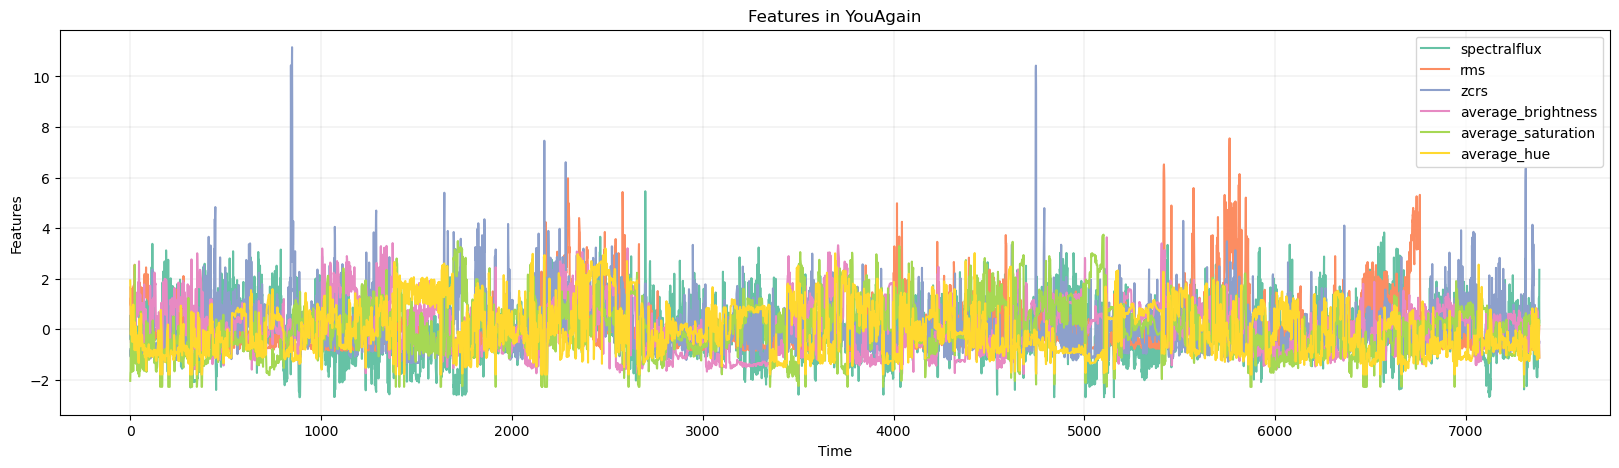

In [ ]:
# plot the features
def plot_features(features, movie):
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title(f'Features in {movie}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Features')
    ax.plot(features)
    ax.legend(features.columns)
    plt.show()

plot_features(concatenated_features, movie)